In [246]:
import torch
import os
import numpy as np
import re
import json
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1

def load_data(folder, epoch):
    dirs = os.listdir(folder)
    df = []
    for d in dirs:
        df1 = []
        run_dir = os.path.join(folder, d)
        f = checkpoint_epoch(run_dir, epoch)
        if f == -1:
            continue
        config = json.load(open(os.path.join(run_dir, 'args.json')))
        ckpt = torch.load(os.path.join(run_dir, f))['densities']
        metrics = torch.load(os.path.join(run_dir, f))['metrics']
        n_steps = len(metrics['train_loss'])
        for step in range(n_steps):
            d = copy.deepcopy(config)
            d.update({'density_eigen': ckpt['density_eigen'][step],
                      'density_weight': ckpt['density_weight'][step],
                      'train_loss': metrics['train_loss'][step],
                      'step': step})
            df.append(d)
    df = pd.DataFrame(df)
    return df


def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.tight_layout()
    # plt.savefig('example.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.max(eigenvalues) + overhead
    lambda_min = np.min(eigenvalues) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

In [247]:
sns.set(style="whitegrid", font_scale=2.0, palette=sns.color_palette("rocket", n_colors=5))
# folder_path = "/fast/ameterez/nips2024_rebuttal/directional_sharpness_convnets_width"
folder_path = "/fast/ameterez/nips2024_rebuttal/hessian_spectrum_width/"
df = load_data(folder_path, 19).reset_index()


/tmp/ipykernel_1384113/3455543258.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(run_dir, f))['densities']
/tmp/ipykernel_1384113/345554

In [248]:
lrs = sorted(df.lr.unique())
print(lrs)

[0.193069772888325, 0.22758459260747882, 0.2682695795279726, 0.31622776601683794, 0.372759372031494, 0.43939705607607904, 0.517947467923121, 0.6105402296585328, 0.7196856730011519, 0.8483428982440719, 1.0]


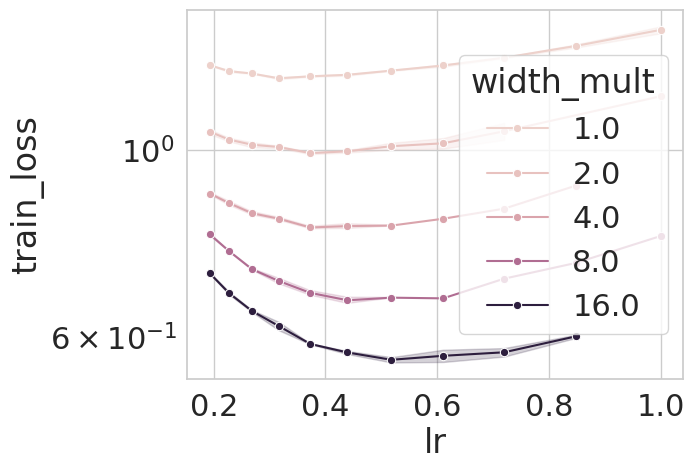

In [250]:
sns.lineplot(df[df['step'] == df['step'].max()], x='lr', y='train_loss', hue='width_mult', marker='o')
plt.yscale('log')

In [257]:
# df2 = df[df['seed'] == 0]
df2 = df[df['lr'] == lrs[6]].reset_index()

In [258]:
width_mults = np.sort(df2.width_mult.unique())

100
100
100
100
100


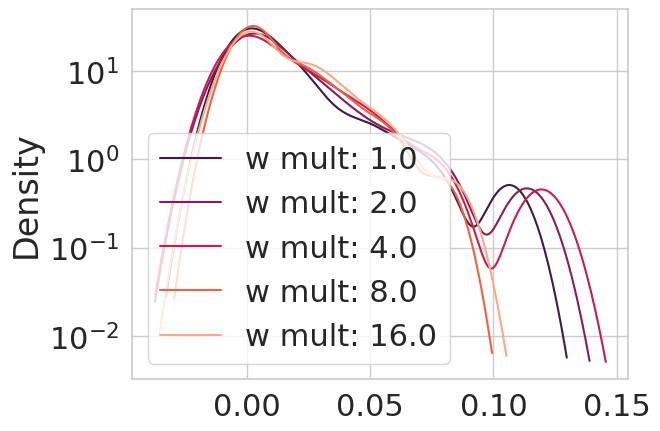

In [262]:
for wm in width_mults:
    df3 = df2[df2['width_mult'] == wm]
    df3 = df3[df3['step'] == df3['step'].max()]
    dens_eig0 = np.array(df3[df3['seed'] == 0]['density_eigen'].values[0]) * wm
    dens_eig1 = np.array(df3[df3['seed'] == 1]['density_eigen'].values[0]) * wm
    # density_eigen = np.array(df3['density_eigen'].values[0]) * wm
    density_eigen = (dens_eig0 + dens_eig1)/2
    sns.kdeplot(density_eigen, label=f'w mult: {wm}')
    print(len(density_eigen))
    # get_esd_plot(density_eigen, density_weight)
plt.yscale('log')
plt.legend()